# NLP2022 - Homework 2


This notebook contains code for a fast processing of data and experiments execution for the second homework of the course Natural Language Processing 2022. It has been completely wrote by Dennis Rotondi 1834864 using the methodologies learned throughout the course.

In [36]:
# imports and deterministic stuff
import os, sys
sys.path.append(os.path.join("..")) #to access hw2 functions
sys.path.append(os.path.join("../..")) #to access model folder
os.environ['WANDB_NOTEBOOK_NAME'] = './nlp_hw2.ipynb' # to avoid a wandb warning
os.environ['TOKENIZERS_PARALLELISM'] = "false" # to avoid deadlock at traning time for the tokenizer

import torch
import numpy as np
import random
import pytorch_lightning as pl
from collections import OrderedDict, Counter
import matplotlib.pyplot as plt
from utils import read_dataset
import wandb
from pytorch_lightning.loggers.wandb import WandbLogger

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)

# to have a better workflow using notebook https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset Analysis

As for the bonus exercise and hw1, I want to start by looking at the data I have to better understand how to proceed in the pre-processing operations. I've read that there are problems with some (sentence-ground truth) pairs, since we are not allowed to do any change I'll directly discharge them for the training phase if needed. I'll do my analysis mostly for the english dataset since it is mandatory and larger (it's possible to reproduce the experiment in different languages).

In [90]:
language = "EN"
data_file = f"../../data/{language}/train.json"

sentences, labels = read_dataset(en_file)
print(f"Number of training sentences ({language}): "+ str(len(sentences.keys())))
# I'm just playing with the field of a sentence_id to understand our data samples.
sentence_id = list(sentences.keys())[0]
print("## SENTENCE {} ##".format(sentence_id))
for key in sentences[sentence_id]:
    print(key)
    print(sentences[sentence_id][key])
print("## LABEL ##")
for key in labels[sentence_id]:
    print(key)
    print(labels[sentence_id][key])

# let's check and count the different frames and roles
verbatlas_frames = Counter()
predicate_roles = Counter()
pos_tags = Counter()

for k in labels:
    verbatlas_frames.update(labels[k]['predicates'])
    pos_tags.update(sentences[k]['pos_tags'])
    for idx in labels[k]['roles']:
        predicate_roles.update(labels[k]['roles'][idx])

Number of training sentences (EN): 5501
## SENTENCE 1996/a/50/18_supp__323:5 ##
words
['Members', 'also', 'asked', 'whether', 'all', 'social', 'groups', 'enjoyed', 'equal', 'access', 'to', 'higher', 'education', '.']
lemmas
['member', 'also', 'ask', 'whether', 'all', 'social', 'group', 'enjoy', 'equal', 'access', 'to', 'higher', 'education', '.']
pos_tags
['NOUN', 'ADV', 'VERB', 'SCONJ', 'DET', 'ADJ', 'NOUN', 'VERB', 'ADJ', 'NOUN', 'ADP', 'ADJ', 'NOUN', 'PUNCT']
dependency_heads
[3, 3, 0, 8, 7, 7, 8, 3, 10, 8, 13, 13, 10, 3]
dependency_relations
['nsubj', 'advmod', 'root', 'mark', 'det', 'amod', 'nsubj', 'ccomp', 'amod', 'obj', 'case', 'amod', 'nmod', 'punct']
predicates
['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', 'BENEFIT_EXPLOIT', '_', '_', '_', '_', '_', '_']
## LABEL ##
predicates
['_', '_', 'ASK_REQUEST', '_', '_', '_', '_', 'BENEFIT_EXPLOIT', '_', '_', '_', '_', '_', '_']
roles
{2: ['agent', '_', '_', 'theme', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], 7: ['_', '_', '_'

In [91]:
print("## VF ##")
print(verbatlas_frames)
# list of frames in the training dataset
l_vf = list(verbatlas_frames.keys())
print(l_vf)
print(len(l_vf))
print("## RL ##")
print(predicate_roles)
p_r = list(predicate_roles.keys())
print(p_r)
print(len(p_r))
print("## PT ##")
print(list(pos_tags.keys()))

## VF ##
Counter({'_': 170997, 'PROPOSE': 542, 'CARRY-OUT-ACTION': 492, 'INCLUDE-AS': 472, 'SPEAK': 393, 'INCREASE_ENLARGE_MULTIPLY': 350, 'SHOW': 287, 'ASK_REQUEST': 271, 'CONTINUE': 270, 'GUARANTEE_ENSURE_PROMISE': 262, 'APPROVE_PRAISE': 257, 'FOLLOW_SUPPORT_SPONSOR_FUND': 237, 'LOAD_PROVIDE_CHARGE_FURNISH': 235, 'GIVE_GIFT': 228, 'REQUIRE_NEED_WANT_HOPE': 214, 'OBLIGE_FORCE': 200, 'AGREE_ACCEPT': 197, 'DECIDE_DETERMINE': 189, 'HELP_HEAL_CARE_CURE': 179, 'INCITE_INDUCE': 175, 'FOCUS': 162, 'STRENGTHEN_MAKE-RESISTANT': 160, 'BEGIN': 157, 'INFORM': 152, 'ESTABLISH': 150, 'AMELIORATE': 148, 'TAKE-INTO-ACCOUNT_CONSIDER': 146, 'ANALYZE': 130, 'ORGANIZE': 126, 'USE': 118, 'NAME': 116, 'CREATE_MATERIALIZE': 113, 'FINISH_CONCLUDE_END': 112, 'EMPHASIZE': 110, 'PRECLUDE_FORBID_EXPEL': 101, 'SEE': 96, 'REFER': 94, 'ANSWER': 94, 'PUT_APPLY_PLACE_PAVE': 87, 'CANCEL_ELIMINATE': 86, 'ACHIEVE': 83, 'ASSIGN-SMT-TO-SMN': 79, 'REDUCE_DIMINISH': 78, 'POSSESS': 73, 'SUMMON': 68, 'ALLY_ASSOCIATE_MARRY': 6

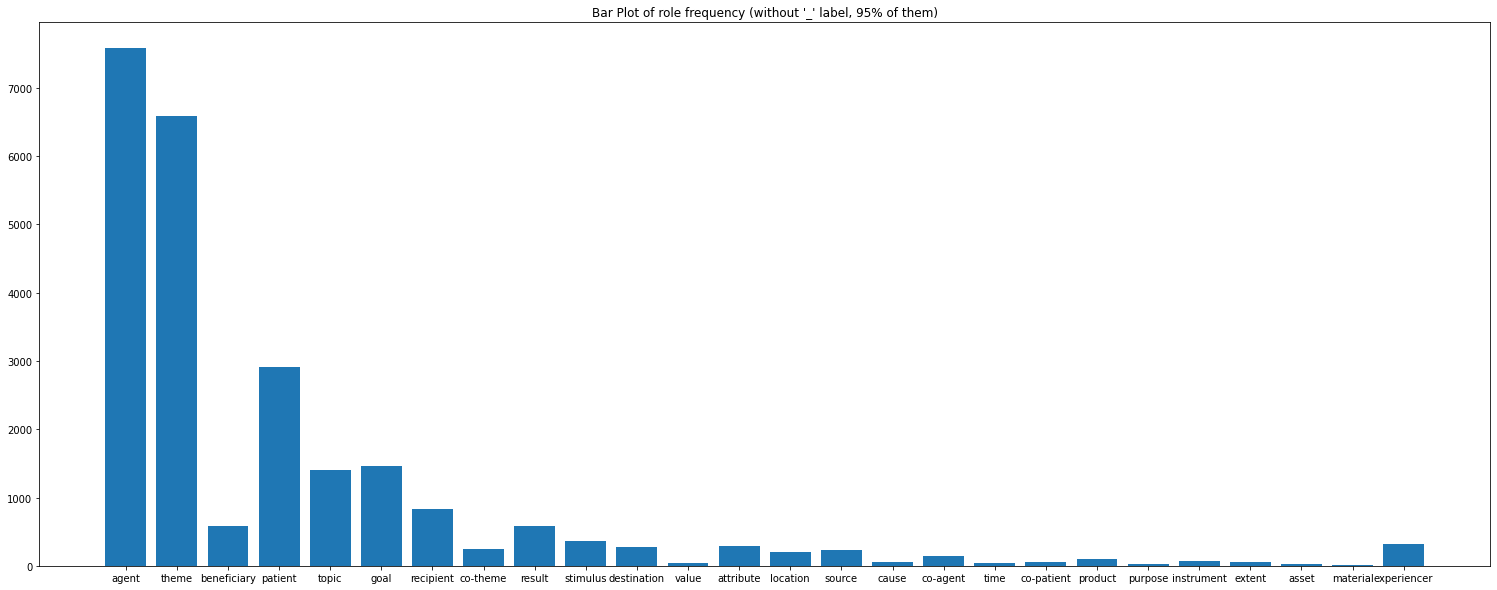

In [92]:
del(predicate_roles["_"])
# to place it in a different position and not have overlapping labels
predicate_roles["experiencer"] = predicate_roles.pop("experiencer")
plt.figure(figsize=(26,10))
_ = plt.bar(predicate_roles.keys(), predicate_roles.values()) 
plt.title("Bar Plot of role frequency (without '_' label, 95% of them)") 
plt.show() #it's possible to notice that most of them are between size 7 and 30


We are clearly not using all the 466 [verbatlas](https://verbatlas.org/) frames but less than 3/4 of them: 303. Working with fewer clusters surely increases the overall performances because the system can only focus on a subset of them. In the next code cell I want to check if in the dev-set I do not have other frames.

In [93]:
dev_sentences, dev_labels = read_dataset(f"../../data/{language}/dev.json")
print(f"Number of training sentences ({language}): "+ str(len(dev_sentences.keys())))
for k in dev_labels:
    verbatlas_frames.update(dev_labels[k]['predicates'])
    for idx in dev_labels[k]['roles']:
        predicate_roles.update(dev_labels[k]['roles'][idx])

l_vf_dev = list(verbatlas_frames.keys())
print(len(l_vf_dev))

Number of training sentences (EN): 1026
307


So there are only 4 more frames in the dev_set wrt the train_set, this information is useful for further consideration when I'll deal with the optional part of this homework.

Now that I'm starting to understand the samples, it's clear that our dataset does not need much pre-processing, since we already have words tokens and associated lemmas for each sentence. Some more useful statistics are on how long are the sentences on average, how many predicates they have and how the distribution of pos-tagging tokens correlate with roles and predicates. I'll rapidly compute them in what follows. 

In [99]:
from mergedeep import merge
sentences_length = list()
predicates_counter = list()
sentences = merge(sentences, labels)
pos_pre_corr = Counter()
pos_role_corr = Counter()

Sentences Length
mean 33.36829667333212
std 15.785117622745252
min 12
max 99
Predicates Counter
mean 2.283584802763134
std 1.2962833133975358
min 0
max 10


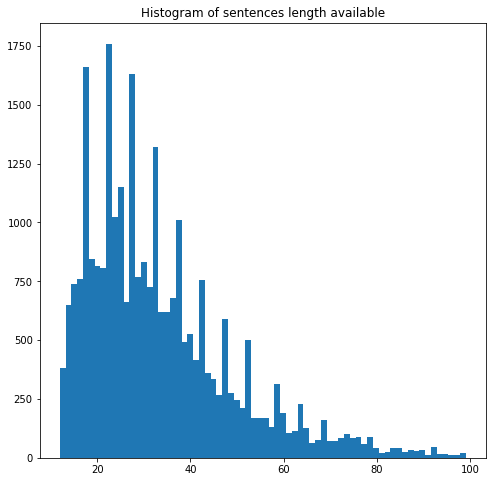

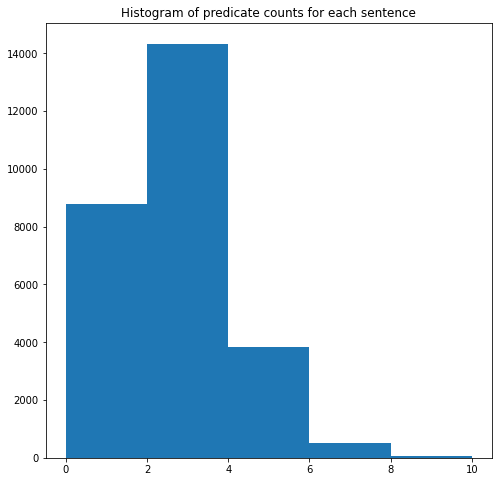

In [105]:
p_tags = list(pos_tags.keys())
for pt in pos_tags:
    pos_pre_corr.update({pt:0})
    pos_role_corr.update({pt:0})

for s in sentences:
    s_l = len(sentences[s]["lemmas"])
    roles = sentences[s]["roles"].keys()
    p_c = len(roles)
    sentences_length.append(s_l)
    predicates_counter.append(p_c)
    for pos, predicate in zip(sentences[s]["pos_tags"], sentences[s]["predicates"]):
        if predicate != "_":
            pos_pre_corr.update({pos:1})
    for r in roles:
        for pos, role in zip(sentences[s]["pos_tags"],sentences[s]["roles"][r]):
            if role != "_":
                pos_role_corr.update({pos:1})
    
sl_np=np.asarray(sentences_length)
pc_np=np.asarray(predicates_counter)

print("Sentences Length")
print("mean", sl_np.mean())
print("std", sl_np.std())
print("min", sl_np.min())
print("max", sl_np.max())

print("Predicates Counter")
print("mean", pc_np.mean())
print("std", pc_np.std())
print("min", pc_np.min())
print("max", pc_np.max())

plt.figure(figsize=(8,8)) 
_ = plt.hist(sl_np, bins = 'auto') 
plt.title("Histogram of sentences length available") 
plt.show()

plt.figure(figsize=(8,8)) 
_ = plt.hist(pc_np, bins = 5) 
plt.title("Histogram of predicate counts for each sentence") 
plt.show()

It's interesting to notice that (for our EN dataset) there are some sentences with 0 and some with 10 predicates, even if the average is slightly more than 2.


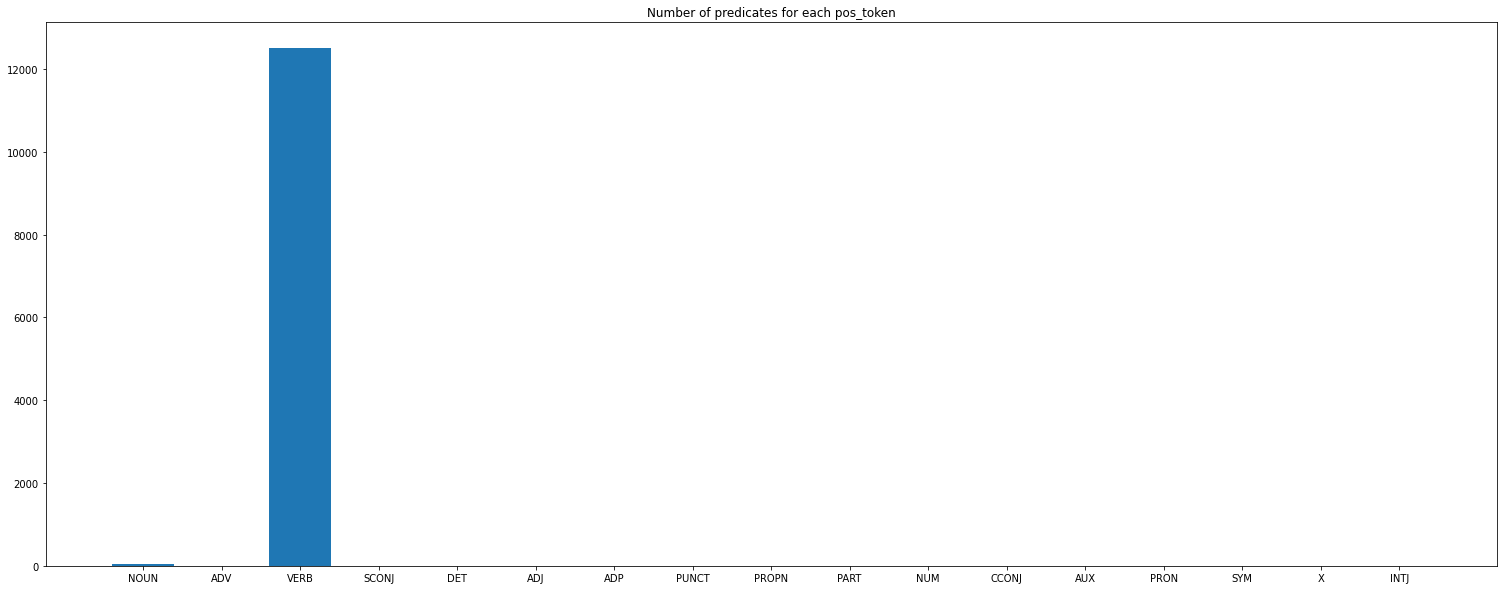

Counter({'VERB': 12502, 'NOUN': 44, 'PROPN': 7, 'AUX': 6, 'ADJ': 2, 'INTJ': 1, 'ADV': 0, 'SCONJ': 0, 'DET': 0, 'ADP': 0, 'PUNCT': 0, 'PART': 0, 'NUM': 0, 'CCONJ': 0, 'PRON': 0, 'SYM': 0, 'X': 0})


In [96]:
plt.figure(figsize=(26,10))
_ = plt.bar(pos_pre_corr.keys(), pos_pre_corr.values()) 
plt.title("Number of predicates for each pos_token") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

print(pos_pre_corr)

A photo is worth a thousand words, if we are able to identify the pos_tag it's also very easy to understand we have a verb or not. (holy grail for task1)

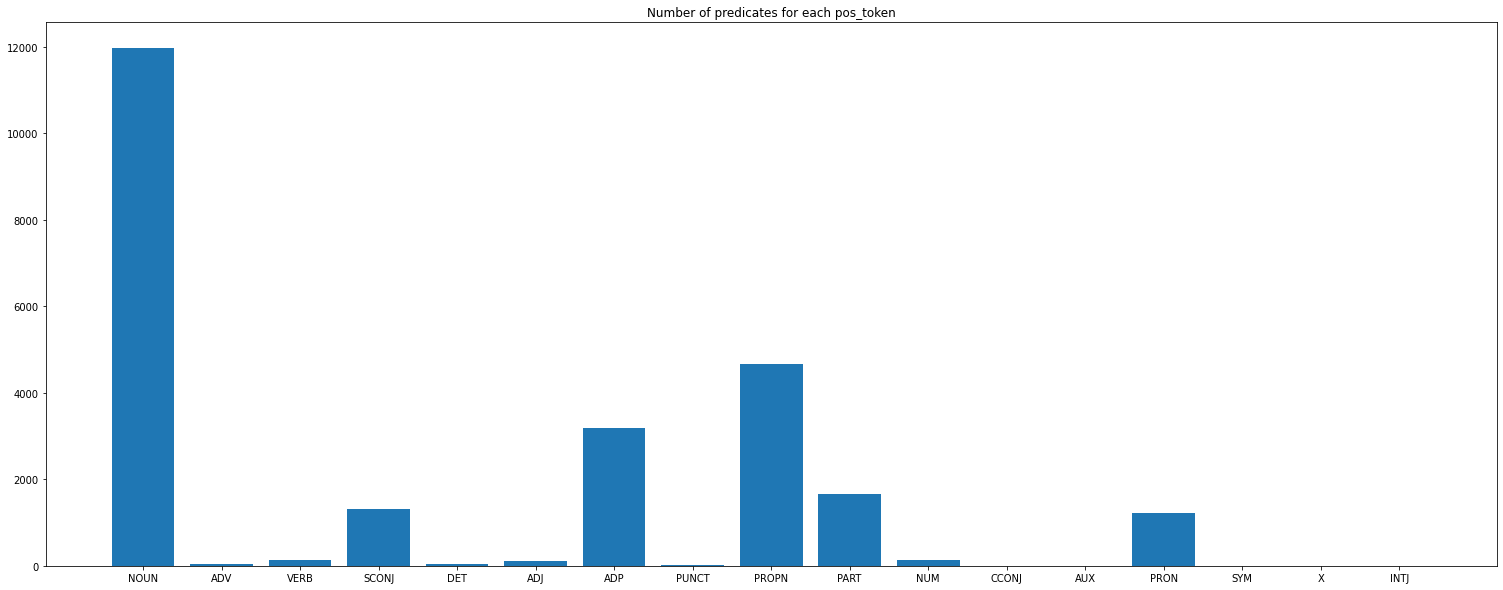

Counter({'NOUN': 11970, 'PROPN': 4655, 'ADP': 3179, 'PART': 1662, 'SCONJ': 1318, 'PRON': 1225, 'VERB': 144, 'NUM': 141, 'ADJ': 111, 'ADV': 43, 'DET': 32, 'PUNCT': 15, 'SYM': 4, 'AUX': 3, 'X': 3, 'CCONJ': 1, 'INTJ': 0})


In [101]:
plt.figure(figsize=(26,10))
_ = plt.bar(pos_role_corr.keys(), pos_role_corr.values()) 
plt.title("Number of predicates for each pos_token") 
plt.show() #it's possible to notice that most of them are between size 7 and 30

print(pos_role_corr)

Also in this case it's clear that there are pos tags that gives more information about which are the arguments, so I'll introduce them in my model if time will allow it.

## Training

Now it's time to train our model. Pytorch-lightning allow that in such a way that it's easy to modularize everything and train with few lines of code all the different models. Moreover using wandb as logger I auto-plot the training evolution in high quality plots and it's also possible to save the training history of the different trials. This will be very useful for comparing the experiments in the report.   

In [ ]:
from datasets_srl import SRL_DataModule
from implementation import HParams, SRL_34
from dataclasses import dataclass, asdict
from pprint import pprint
from utils import read_dataset, evaluate_argument_classification, evaluate_argument_identification
from mergedeep import merge

# these are some parameters that allow as I said to modularize the training. We need to store the hypermarameters of the model (lr, wd, ...), the language
# and the task on which we want to perform the training.
hparams = asdict(HParams())
print(hparams)
languages = ["EN", "ES", "FR"]
tasks = ["34", "234", "1234"]
models = {"34": SRL_34}


language = languages[0]
task = tasks[0]
epochs = 100
SRL_Model = models[task]
# after reading the dataset I merge the two dicts (sentences and labels) since there is a field in common (predicate)
# and it's only a waste of space keeping it in memory 2 copies of it.
sentences = merge(*read_dataset("../../data/"+language+"/train.json"))
sentences_test = merge(*read_dataset("../../data/"+language+"/dev.json"))

In [ ]:
data = SRL_DataModule(hparams, task, sentences, sentences_test)
model = SRL_Model(hparams=hparams, sentences_for_evaluation=sentences_test)

In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
# Define the logger
# https://www.wandb.com/articles/pytorch-lightning-with-weights-biases.
# NOTE: to use wandb properly you need to login in wandb (need an account) 
# or use a different logger eg. TensorBoard, I'm used to this one so I'll go for it.
# to login: https://docs.wandb.ai/ref/cli/wandb-login
wandb.require("service")
wandb_logger = WandbLogger(project="SRL_"+task, log_model = True)
wandb_logger.experiment.watch(model, log = 'False', log_freq = 100000)
# Define the trainer
metric_to_monitor =  "f1" # f1 of argument classification, also possible eg 'avg_val_loss'
mode = "max" #you want to maximixe or minimize the metric?
# we employ the early stopping technique to avoid hours of usuless training, pl gives it for free
early_stop_callback = EarlyStopping(monitor = metric_to_monitor, min_delta = 0.00, patience = 10, verbose = True, mode = mode)
# it is also useful to keep track of the best model during the epochs (if you remember I did all this manually last hw)or use a different logger,
# we have a callback even for this.
checkpoint_callback = ModelCheckpoint(
                        save_top_k = 1,
                        monitor = metric_to_monitor,
                        mode = mode,
                        dirpath = "../../model",
                        filename = "SRL_"+task+"_"+language+"-{epoch:02d}-{f1:.4f}",
                        verbose = True
                    )
# the trainer collect all the useful informations so far for the training 
trainer = pl.Trainer(logger = wandb_logger,
                    max_epochs = epochs, 
                    gpus = 1,
                    callbacks = [early_stop_callback, checkpoint_callback])    

save_ckpt_file = "../../model/SRL_{}_{}_last.ckpt".format(task, language)

In [ ]:
# Start the training, without initialized weights
trainer.fit(model, data)
# Log the trained model
trainer.save_checkpoint(save_ckpt_file)

To continue the training it's possible to just increase the number of epochs and create a new trainer, also possible to fine tune the model for another language.

In [ ]:
resume_ckpt = save_ckpt_file # or use another language / pre-trained model.
epochs += 10 # increase the maximum number of epochs
trainer = pl.Trainer(logger = wandb_logger,
                    max_epochs = epochs, 
                    gpus = 1,
                    callbacks = [early_stop_callback, checkpoint_callback],
                    resume_from_checkpoint = resume_ckpt)    
trainer.fit(model, data)
trainer.save_checkpoint(save_ckpt_file)

In [ ]:
# if you have trained for enough epochs you can now finish logging with wandb to have your plot.
wandb.finish()

In [ ]:
#to upload online the run after finishing (you will have a string like the one below, just execute in on terminal or here)
!wandb sync /home/dennis/Desktop/nlp2022-hw2/hw2/stud/wandb/offline-run-20220712_105118-2uum41pe

### Confusion Matrix Analysis for argument classification

Now that we have our trained model it's interesting to understand where it performs better and where not. Recalling that from the english dataset analysis these were the numbers of different roles:

{'_': 437392, 'agent': 7581, 'theme': 6593, 'patient': 2907, 'goal': 1463, 'topic': 1403, 'recipient': 837, 'beneficiary': 590, 'result': 577, 'stimulus': 367, 'experiencer': 319, 'attribute': 294, 'destination': 276, 'co-theme': 253, 'source': 229, 'location': 198, 'co-agent': 145, 'product': 95, 'instrument': 70, 'co-patient': 60, 'extent': 54, 'cause': 51, 'value': 45, 'time': 35, 'asset': 28, 'purpose': 25, 'material': 11}

by inspection could be possible to estimate a correlation between the number of samples and the results.

In [ ]:
# import and utils for this evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from typing import Dict, List, Any
from utils import evaluate_argument_classification, evaluate_argument_identification

def flat_dict_roles(sentences: Dict[str, Dict[str, List[str]]]) -> List[Any]:
    list_tokens = list()
    for s in sentences:
        for l in sentences[s]["roles"]:
            list_tokens+=[token for token in sentences[s]["roles"][l]]
    return list_tokens

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
best_ckpt = "../../model/SRL_34-epoch=26-f1=0.8389.ckpt"
model = SRL_34.load_from_checkpoint(best_ckpt)

In [ ]:
predict = model.to(device).predict(sentences_test, require_ids=True)

In [ ]:
print("AI")
print(evaluate_argument_identification(sentences_test, predict))
print("AC")
print(evaluate_argument_classification(sentences_test, predict))

flat_labels_s = flat_dict_roles(sentences_test)
flat_predictions_s = flat_dict_roles(predict)
all_labels = ['_', 'agent', 'theme', 'beneficiary', 'patient', 'topic', 'goal', 'recipient', 'co-theme', 'result', \
    'stimulus', 'experiencer', 'destination', 'value', 'attribute', 'location', 'source', 'cause', 'co-agent', \
    'time', 'co-patient', 'product', 'purpose', 'instrument', 'extent', 'asset', 'material']

cm = confusion_matrix(flat_labels_s, flat_predictions_s, labels=all_labels, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels)
fig, ax = plt.subplots(figsize=(36,36))
disp.plot(ax=ax) #7162

As expected the fewer the samples the worst the performances.

## TODO: NOW the confusion matrix 

## TOREMOVE

In [ ]:
a = torch.load("../../model/srl_34_EN.ckpt")

In [ ]:
print(a)

In [ ]:
from transformers import AutoModel
from transformers import AutoTokenizer

auto_model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
sequence = "Using a Transformer network is simple"
sequence2 = "we ciao"
# tokens = tokenizer.tokenize(sequence)

# # print(tokens)

# ids = tokenizer.convert_tokens_to_ids(tokens)
# # print(ids)

tokenized_inputs = tokenizer([[sequence, "simple"],[sequence2, "ciao"]],padding=True, return_tensors="pt")  # "pt" -> return PyTorch torch.Tensor objects, rather than a list of tokens

print(tokenized_inputs)
print(tokenized_inputs['input_ids'].shape)
print(tokenized_inputs.word_ids(0))
print(tokenized_inputs.word_ids(1))
# NOTE: in the dataset use those word ids to average and simply filter for example... MAY NOT WORK:...
sequence3 = ["we", "ciao"]
print("second - use this one!!")
tokenized_inputs2 = tokenizer.batch_encode_plus([([sequence.split(), ["simple"]]),(sequence3,["ciao"])], add_special_tokens=True, is_split_into_words=True, padding=True, return_tensors="pt")  # "pt" -> return PyTorch torch.Tensor objects, rather than a list of tokens
print(tokenized_inputs2)
print(tokenized_inputs2['input_ids'].shape)
print(tokenized_inputs2.word_ids(0))
a, b, c = tokenizer.batch_encode_plus([([sequence.split(), ["simple"]]),(sequence3,["ciao"])], add_special_tokens=True, is_split_into_words=True, padding=True, return_tensors="pt")  # "pt" -> return PyTorch torch.Tensor objects, rather than a list of tokens 
print("aaa")
print(b)
print("aaa")
# print(tokenized_inputs2.word_ids(1))
# sequence_a = "This is a short sequence."
# sequence_b = "This is a rather long sequence. It is at least longer than the sequence A."
# print("test")
# padded_sequences = tokenizer([sequence_a, sequence_b], padding=True)
# print(padded_sequences)

transformers_outputs = auto_model(**tokenized_inputs)#['input_ids']
# print(transformers_outputs)
transformers_outputs_sum = torch.stack(transformers_outputs.hidden_states[-4:], dim=0).sum(dim=0)
print(transformers_outputs_sum.shape)
# I should remove 2 sep and 1 cls, 1 additional token -> final size 7



# filter_toke = tokenized_inputs['input_ids'][:, 1:-3, ...]
# print(filter_toke.shape)
# labels  = tokenized_inputs.word_ids()[1:-3]
# samp_size = filter_toke.shape[1]
# M = torch.zeros(max(labels)+1, samp_size)
# M[labels, torch.arange(samp_size)] = 1
# print(M)
# M = torch.nn.functional.normalize(M, p=1, dim=1)
# print(M)
# torch.mm(M, filter_toke[0]).shape

# i want to have an ID to unde
# item["role_id"] = (item["role_labels"] == self.labels_to_id["_"]).long()

In [ ]:
samples = torch.Tensor([[
                     [0.1, 0.1],    #-> group / class 1
                     [0.2, 0.2],    #-> group / class 2
                     [0.4, 0.4],    #-> group / class 2
                     [0.0, 0.0]     #-> group / class 0
              ],
              [
                     [0.1, 0.1],    #-> group / class 1
                     [0.2, 0.2],    #-> group / class 1
                     [0.0, 0.0],    #-> group / class 0
                     [12.0, 12.0]   #-> group / class 0
              ]])

from transformers_embedder.embedder import TransformersEmbedder
labels = torch.LongTensor([[1, 2, 2, 2],[1,2,0,2]])


print(TransformersEmbedder.merge_scatter(samples, labels))
print(TransformersEmbedder.merge_scatter(samples, labels).shape)


In [ ]:
# code taken from Riccardo Orlando transformer embedding https://github.com/Riccorl/transformers-embedder
# it is needed to average the wordpieces after the tokenization to have more reliable embeddig. This is 
# useful because for OOV words (or other languages) we can capture more informations than simply using
# the first token. 
def merge_scatter(embeddings: torch.Tensor, indices: torch.Tensor) -> torch.Tensor:
    """
    Minimal version of ``scatter_mean``, from `pytorch_scatter
    <https://github.com/rusty1s/pytorch_scatter/>`_
    library, that is compatible for ONNX but works only for our case.
    It is used to compute word level embeddings from the transformer output.
    Args:
        embeddings (:obj:`torch.Tensor`):
            The embeddings tensor.
        indices (:obj:`torch.Tensor`):
            The sub-word indices.
    Returns:
        :obj:`torch.Tensor`
    """

    def broadcast(src: torch.Tensor, other: torch.Tensor):
        """
        Broadcast ``src`` to match the shape of ``other``.
        Args:
            src (:obj:`torch.Tensor`):
                The tensor to broadcast.
            other (:obj:`torch.Tensor`):
                The tensor to match the shape of.
        Returns:
            :obj:`torch.Tensor`: The broadcasted tensor.
        """
        for _ in range(src.dim(), other.dim()):
            src = src.unsqueeze(-1)
        src = src.expand_as(other)
        return src

    def scatter_sum(src: torch.Tensor, index: torch.Tensor) -> torch.Tensor:
        """
        Sums the elements in ``src`` that have the same indices as in ``index``.
        Args:
            src (:obj:`torch.Tensor`):
                The tensor to sum.
            index (:obj:`torch.Tensor`):
                The indices to sum.
        Returns:
            :obj:`torch.Tensor`: The summed tensor.
        """
        index = broadcast(index, src)
        size = list(src.size())
        size[1] = index.max() + 1
        print(size)
        print(src.dtype)
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(1, index, src)

    # replace padding indices with the maximum value inside the batch
    indices[indices == -1] = torch.max(indices)
    merged = scatter_sum(embeddings, indices)
    ones = torch.ones(
        indices.size(), dtype=embeddings.dtype, device=embeddings.device
    )
    count = scatter_sum(ones, indices)
    count.clamp_(1)
    count = broadcast(count, merged)
    merged.true_divide_(count)
    return merged[:,:-1,:] #added by me to remove a batch!

In [ ]:
torch.tensor([1,2,None],dtype=torch.float)

In [ ]:
pip install transformers-embedder

In [ ]:
torch.cuda.is_available()

self.vae=VAE.load_from_checkpoint(hparams.vae.pth_folder)
self.vae.freeze() #we do not want to train it

In [ ]:
import transformers_embedder as tre
from transformers import AutoModel
from transformers import AutoTokenizer
# tokenizer = tre.Tokenizer("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
auto_model = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)


In [ ]:
for param in auto_model.encoder.layer[11].parameters():
    print(param)

In [ ]:
batch = [
    ["This", "is", "a", "sample", "sentence", "1"],
    ["This", "is", "sample", "sentence", "2"],
    ["This", "is", "a", "sample", "sentence", "3"],
    # ...
    ["This", "is", "a", "sample", "sentence", "n", "for", "batch"],
]

batch_pair = [
    ["This", "is", "a", "sample", "sentence", "pair", "1"],
    ["This", "is", "sample", "sentence", "pair", "2"],
    ["This", "is", "a", "sample", "sentence", "pair", "3"],
    # ...
    ["This", "is", "a", "sample", "sentence", "pair", "n", "for", "batch"],
]
tokenizer(batch, batch_pair, padding=True, return_tensors="pt", is_split_into_words=True)